In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import requests
import datetime
from matplotlib.lines import Line2D
import matplotlib as mpl
import copy
import math

from tqdm.auto import tqdm
from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

In [2]:
import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.sim import run_simple_sim
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_starboard_sector_expirations, get_cum_capped_qa_power
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df

In [3]:
# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# set the simulation start date
today = datetime.date(2022, 12, 1) 
DATA_LAG_DAYS = 0
current_date = today - datetime.timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 15)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast timeframe
forecast_lenght = int(365*5)
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-15
2022-12-01
2027-11-30


In [4]:
_, historical_renewal_rate = u.get_historical_renewal_rate(start_date, current_date)
t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)

# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

In [5]:
fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

In [6]:
def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
#             df_out[c] = df_out[c].clip(lower=1e-4)
            df_out[c] = df_out[c].clip(lower=0)
    return df_out

# add ROI to trajectory
def add_generated_quantities(cil_rbp, cil_qap, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
#     df['day_pledge_per_QAP'] = SECTOR_SIZE * df['day_locked_pledge'] / (df['day_onboarded_power_QAP'] + df['day_renewed_power_QAP'])
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['day_onboarded_power_QAP'])
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / cil_rbp.network_QAP
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(duration).sum().shift(-duration+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']
    
    # compute ROI based on QAP
    cil_qap['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_qap['day_locked_pledge']-cil_qap['day_renewed_pledge'])/(cil_qap['day_onboarded_power_QAP'])
    cil_qap['day_rewards_per_sector'] = SECTOR_SIZE * cil_qap.day_network_reward / cil_qap.network_QAP
    cil_qap['1y_return_per_sector'] = cil_qap['day_rewards_per_sector'].rolling(duration).sum().shift(-duration+1).values.flatten()
    cil_qap['1y_sector_roi'] = cil_qap['1y_return_per_sector'] / cil_qap['day_pledge_per_QAP']
    
    # understand delta between RBP and QAP
    def get_delta(key):
        return cil_qap[key] - cil_rbp[key]
    
    delta_df = pd.DataFrame()
    delta_df['date'] = cil_rbp['date']
    delta_df['network_baseline'] = cil_rbp['network_baseline']
    delta_df['network_RBP'] = cil_rbp['network_RBP']
    delta_df['network_QAP'] = cil_rbp['network_QAP']
    
    delta_df['network_locked'] = get_delta('network_locked')
    delta_df['circ_supply'] = get_delta('circ_supply')
    delta_df['circ_supply_pct'] = delta_df['circ_supply']/cil_rbp['circ_supply']
    delta_df['locked_over_supply'] = (cil_qap['network_locked']/cil_qap['circ_supply']) - (cil_rbp['network_locked']/cil_rbp['circ_supply'])
    delta_df['day_locked_pledge'] = get_delta('day_locked_pledge')
    
    delta_df['day_pledge_per_QAP'] = get_delta('day_pledge_per_QAP')    
    delta_df['day_pledge_per_QAP_pctincr'] = get_delta('day_pledge_per_QAP')/cil_rbp['day_pledge_per_QAP'] * 100
    delta_df['day_rewards_per_sector'] = get_delta('day_rewards_per_sector')
    delta_df['1y_return_per_sector'] = get_delta('1y_return_per_sector')
    delta_df['1y_sector_roi'] = get_delta('1y_sector_roi')

    delta_df['capped_power'] = get_delta('capped_power')
    delta_df['network_time'] = get_delta('network_time')
    delta_df['cum_baseline_reward'] = get_delta('cum_baseline_reward')
    delta_df['day_network_reward'] = get_delta('day_network_reward')
    delta_df['day_network_reward_pctincr'] = get_delta('day_network_reward')/cil_rbp['day_network_reward'] * 100
    
    delta_df['network_RBP'] = cil_rbp['network_RBP']
    delta_df['network_QAP'] = cil_rbp['network_QAP']
    
    return cil_rbp, cil_qap, delta_df

def run_sim(rb_onboard_power_pred, renewal_rate_vec_pred, fil_plus_rate_pred,
            duration=365, duration_m=None, qap_mode='basic', intervention_config={}):
        
    # api for power-forecasting and circ-supply are slightly different
    renewal_rate_vec = np.concatenate([historical_renewal_rate, renewal_rate_vec_pred])    

    res = get_sector_expiration_stats(start_date, current_date,end_date)
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
    current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec[-int(forecast_lenght):],
        fil_plus_rate_pred,
        duration,
        forecast_lenght,
        duration_m=duration_m,
        qap_method=qap_mode,
        intervention_config=intervention_config
    )

    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
    
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    vest_df = compute_vesting_trajectory_df(start_date, end_date)
    
    mint_df_rbpbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'rbp'
    )
    mint_df_qapbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'qap'
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df_rbp = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec,
        burnt_fil_vec,
        vest_df,
        mint_df_rbpbase,
        known_scheduled_pledge_release_full_vec
    )
    cil_df_qap = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec,
        burnt_fil_vec,
        vest_df,
        mint_df_qapbase,
        known_scheduled_pledge_release_full_vec
    )
    
    rbp_roi, qap_roi, delta_roi = add_generated_quantities(cil_df_rbp, cil_df_qap, duration=duration)
    
    return_dict = {
        'rbp_roi': rbp_roi,
        'qap_roi': qap_roi,
        'delta_roi': delta_roi,
        'renewal_rate_vec': renewal_rate_vec,
        'rb_onboard_power_pred': rb_onboard_power_pred,
        'fil_plus_rate_pred': fil_plus_rate_pred
    }
    
    return return_dict

In [7]:
def early_cc_renewal(scenario_info, shock_date, renewal_cc_pct=0.5, shock_length_days=10):
    
    renewal_rate = scenario['renewal_rate_vec']
    filplus_rate = scenario['fil_plus_rate_pred']
    
    t = np.asarray([datetime.timedelta(days=x) + today for x in range(forecast_lenght)])

    ii_shock_start = np.where(t >= shock_date)[0][0]
    total_auc = np.sum(renewal_rate)
    auc_move = np.sum(renewal_rate[ii_shock_start+shock_length_days:] * renewal_cc_pct)
    rr_new = np.zeros_like(renewal_rate)
    rr_new[0:ii_shock_start] = renewal_rate[0:ii_shock_start]
    jj1 = ii_shock_start; jj2 = ii_shock_start+shock_length_days
    rr_new[jj1:jj2] = auc_move/shock_length_days + renewal_rate[jj1:jj2]
    rr_new[jj2:] = renewal_rate[jj2:] * (1-renewal_cc_pct)
    
#     # apply shock
#     ii_shock_start = np.where(t >= shock_date)[0][0]
#     total_auc = np.sum(renewal_rate)
#     auc_after_shock = np.sum(renewal_rate[ii_shock_start:])
#     rr_move = auc_after_shock * renewal_cc_pct
#     auc_after_shock_complete = (1-renewal_cc_pct) * auc_after_shock
#     rr_new = np.zeros_like(renewal_rate)
#     running_auc = 0
#     for ii in range(len(renewal_rate)):
#         tt = t[ii]
#         if tt < shock_date:
#             rr_new[ii] = renewal_rate[ii]
#         else:
#             remaining_auc_to_fill = total_auc - running_auc
#             if remaining_auc_to_fill >= auc_after_shock_complete:
#                 rr_new[ii] = 1  # max out renewal rate until we hit the target
#             else:
#                 rr_new[ii] = renewal_rate[ii] * (1-rr_pct_cc)

#         running_auc += rr_new[ii]
        
    # sanity check
    assert math.isclose(np.sum(renewal_rate), np.sum(rr_new))  # check AUCs
        
    return rr_new

In [62]:
pct_max = 0.7
target = 180
intervention_date=datetime.date(2023,3,15)
duration=365*3

sp = curated.forecast_smooth_scenario(forecast_lenght,
                                      pct_max,
                                      target,
                                      rb_onboard_setting = 'smooth_pcttarget',
                                      renewal_rate_setting = 'smooth_pcttarget',
                                      filplus_rate_setting = 'historical_median')

sim_vec = [
    {'name': '1A', 'sim_inputs': sp,
     'kwargs':{'duration': duration, 'duration_m': lambda d: d/365., 'qap_mode':'tunable',
               'intervention_config': {
                   'type': 'noop',
                   'intervention_date': intervention_date,
                   'simulation_start_date': today,
                   'sdm_cc_onboard_before_intervention': False,
                   'sdm_cc_onboard_after_intervention': True,
                   'sdm_cc_renew_before_intervention': False,
                   'sdm_cc_renew_after_intervention': True
               }
              }
    },
    {'name': '1B', 'sim_inputs': sp,
     'kwargs':{'duration': duration, 'duration_m': lambda d: d/365., 'qap_mode':'tunable',
               'intervention_config': {
                   'type': 'cc_early_renewal',
                   'intervention_date': intervention_date,
                   'simulation_start_date': today,
                   'sdm_cc_onboard_before_intervention': False,
                   'sdm_cc_onboard_after_intervention': True,
                   'sdm_cc_renew_before_intervention': False,
                   'sdm_cc_renew_after_intervention': True
               }
              }
    },
    {'name': '2A', 'sim_inputs': sp,
     'kwargs':{'duration': duration, 'duration_m': lambda d: d/365., 'qap_mode':'tunable',
               'intervention_config': {
                   'type': 'noop',
                   'intervention_date': intervention_date,
                   'simulation_start_date': today,
                   'sdm_cc_onboard_before_intervention': False,
                   'sdm_cc_onboard_after_intervention': True,
                   'sdm_cc_renew_before_intervention': False,
                   'sdm_cc_renew_after_intervention': False
               }
              }
    }
]

In [69]:
duration_loop_results = {}
for sim in sim_vec:
    sim_inputs = sim['sim_inputs']
    kwargs = sim['kwargs']
    return_dict = run_sim(sim_inputs['rb_onboard_power'], sim_inputs['renewal_rate'], sim_inputs['filplus_rate'],
                          **kwargs)
    duration_loop_results[sim['name']] = return_dict

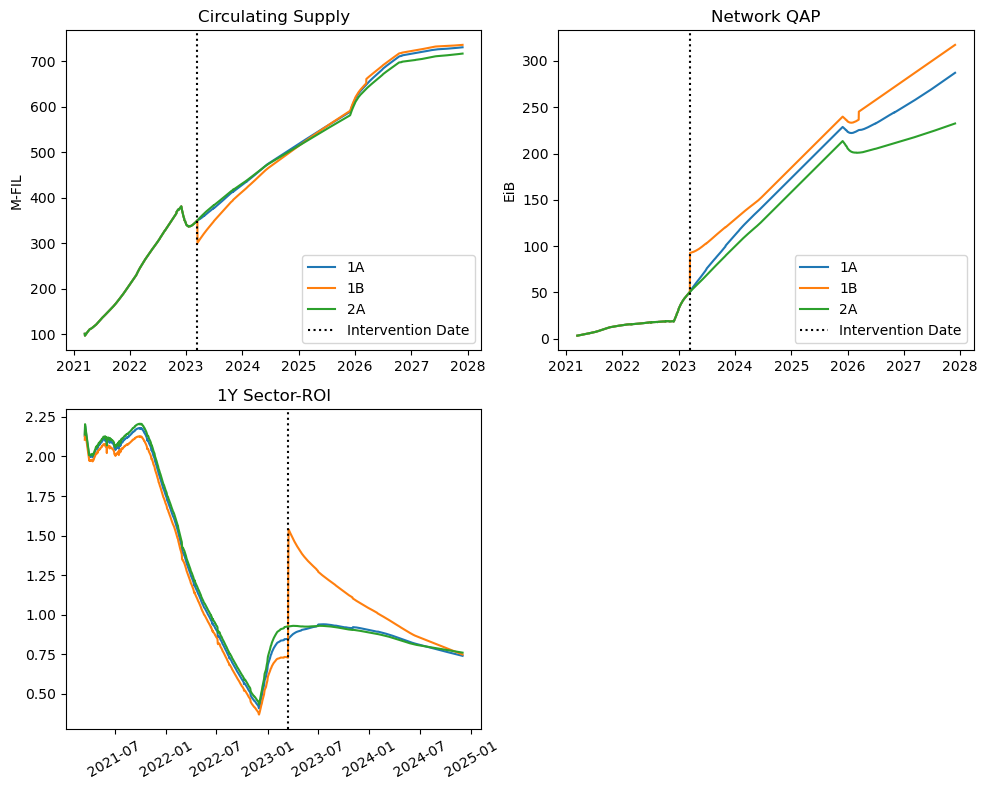

In [70]:
EIB = 2 ** 60
MEGA = 1_000_000

plt.figure(figsize=(10,8))
r1a = duration_loop_results['1A']['rbp_roi']
r1b = duration_loop_results['1B']['rbp_roi']
r2a = duration_loop_results['2A']['rbp_roi']

plt.subplot(2,2,1)
plt.plot(r1a['date'], r1a['circ_supply'] / MEGA, label='1A')
plt.plot(r1b['date'], r1b['circ_supply'] / MEGA, label='1B')
plt.plot(r2a['date'], r2a['circ_supply'] / MEGA, label='2A')
# plt.plot(r2a['date'], (r1a['circ_supply'] - r2a['circ_supply']) / MEGA, label='1A-2A')
plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')

plt.ylabel('M-FIL')
plt.title('Circulating Supply')
plt.legend()

plt.subplot(2,2,2)
plt.plot(r1a['date'], r1a['network_QAP']/EIB, label='1A')
plt.plot(r1b['date'], r1b['network_QAP']/EIB, label='1B')
plt.plot(r2a['date'], r2a['network_QAP']/EIB, label='2A')

# plt.plot(r1a['date'], r1a['network_RBP']/EIB, label='1A')
# plt.plot(r1b['date'], r1b['network_RBP']/EIB, label='1B')
# plt.plot(r2a['date'], r2a['network_RBP']/EIB, label='2A')

# plt.plot(r2a['date'], (r1a['network_QAP'] - r2a['network_QAP'])/EIB, label='$\Delta$ QAP')
# plt.plot(r2a['date'], (r1a['network_RBP'] - r2a['network_RBP'])/EIB, label='$\Delta$ RBP')
plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')
plt.title('Network QAP')
plt.ylabel('EiB')
ax = plt.gca()
ax.legend()
# ax2 = ax.twinx()
# ax2.plot(r2a['date'], np.gradient(r1a['network_QAP'])/EIB, 
#          color='green', label='$\Delta$ QAP Gradient (1A)')
# ax2.plot(r2a['date'], np.gradient(r2a['network_QAP'])/EIB, 
#          color='purple', label='$\Delta$ QAP Gradient (2A)')


# ax2.legend()
# ax2.tick_params(axis='y', labelcolor='green')

plt.subplot(2,2,3)
plt.plot(r1a['date'], r1a['1y_sector_roi'], label='1A')
plt.plot(r1b['date'], r1b['1y_sector_roi'], label='1B')
plt.plot(r2a['date'], r2a['1y_sector_roi'], label='2A')
# plt.plot(r2a['date'], r1a['1y_sector_roi']-r2a['1y_sector_roi'])
plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')
plt.title('1Y Sector-ROI')
plt.xticks(rotation=30)

# plt.subplot(3,2,4)
# plt.plot(r2a['date'], r1a['network_locked_reward']-r2a['network_locked_reward'])
# plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')
# plt.title('Locked Reward')
# plt.xticks(rotation=30)

# plt.subplot(3,2,5)
# plt.plot(r2a['date'], r1a['network_locked_pledge']-r2a['network_locked_pledge'])
# plt.axvline(intervention_date, linestyle=':', color='k', label='Intervention Date')
# plt.title('Locked Pledge')
# plt.xticks(rotation=30)

plt.tight_layout()